In [567]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os

In [568]:
# Define a simple PixelCNN model for RGBA images
class PixelCNN(nn.Module):
    def __init__(self, channels=4, kernel_size=7, hidden_dim=64):
        super(PixelCNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)
        self.conv3 = nn.Conv2d(hidden_dim, channels * 256, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [569]:
class RGBADataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.data = []
        for file_path in file_paths:
            image = np.array(Image.open(file_path).convert("RGBA"))
            self.data.append(image)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image_pil = Image.fromarray(np.uint8(image * 255))  # Convert to PIL Image
        if self.transform:
            image_pil = self.transform(image_pil)
        return image_pil

In [570]:
def generate_images(model, device, num_images=10, channels=4, height=64, width=64):
    model.eval()
    with torch.no_grad():
        images = torch.zeros(num_images, channels, height, width).to(device)
        for i in range(height):
            for j in range(width):
                out = model(images)
                out = torch.softmax(out, dim=1)  # Apply softmax to convert to probability distribution
                pixel = torch.multinomial(out[:, :, i, j], 1).float() / 255.0
                images[:, :, i, j] = pixel.view(1, 1, 1)
    return images


In [571]:
# Main training loop
def train_pixelcnn(model, dataloader, optimizer, criterion, num_epochs=10, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            optimizer.zero_grad()
            images = data.to(device)
            output = model(images)
            loss = criterion(output.permute(0, 2, 3, 1).contiguous().view(-1, 256), images.permute(0, 2, 3, 1).contiguous().view(-1).long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")

In [572]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "SkinData/data/alex/"
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

# Dataset and DataLoader setup
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = RGBADataset(file_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [573]:
# Model, optimizer, and criterion setup
model = PixelCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [574]:
# Training
train_pixelcnn(model, dataloader, optimizer, criterion, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 42/42 [00:02<00:00, 14.45batch/s]


Epoch 1/10, Loss: 3.9054746741340276


Epoch 2/10: 100%|██████████| 42/42 [00:02<00:00, 15.95batch/s]


Epoch 2/10, Loss: 1.074300487836202


Epoch 3/10: 100%|██████████| 42/42 [00:02<00:00, 16.66batch/s]


Epoch 3/10, Loss: 0.23065844218113593


Epoch 4/10: 100%|██████████| 42/42 [00:02<00:00, 17.87batch/s]


Epoch 4/10, Loss: 0.014797886822461373


Epoch 5/10: 100%|██████████| 42/42 [00:02<00:00, 16.85batch/s]


Epoch 5/10, Loss: 0.0053996066313369995


Epoch 6/10: 100%|██████████| 42/42 [00:02<00:00, 18.14batch/s]


Epoch 6/10, Loss: 0.003313058412112739


Epoch 7/10: 100%|██████████| 42/42 [00:02<00:00, 17.01batch/s]


Epoch 7/10, Loss: 0.0022871732417981895


Epoch 8/10: 100%|██████████| 42/42 [00:02<00:00, 18.06batch/s]


Epoch 8/10, Loss: 0.0016935282259336894


Epoch 9/10: 100%|██████████| 42/42 [00:02<00:00, 16.94batch/s]


Epoch 9/10, Loss: 0.001319630747145441


Epoch 10/10: 100%|██████████| 42/42 [00:02<00:00, 18.15batch/s]

Epoch 10/10, Loss: 0.001055424758219271


In [575]:
# Generate and display images
generated = generate_images(model, device, num_images=1)

In [576]:
print(generated[0])

tensor([[[0.0000, 1.0039, 3.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 3.0118,  ..., 0.0000, 3.0118, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 1.0039, 3.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 3.0118,  ..., 0.0000, 3.0118, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 1.0039, 3.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


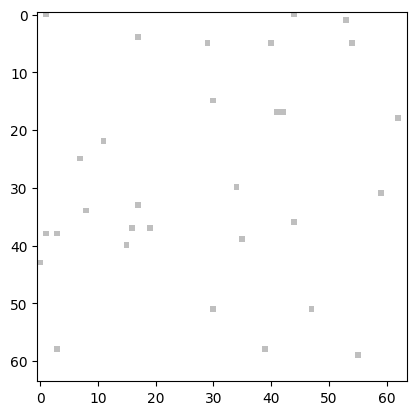

In [577]:
# 画像を正規化
image_tensor = generated / 2
# NumPy配列に変換して表示
image = image_tensor[0].cpu().numpy().transpose(1, 2, 0)
plt.imshow(image)
plt.show()